In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import numba
from numba import prange
import xgboost as xgb
from sklearn.inspection import permutation_importance
import shap

## Data Preparation

In [2]:
data = pd.read_csv("wine_dataset.csv")

In [3]:
data["type"] = data["type"].replace({'white': 1, 'red': 0})

In [4]:
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
data.tail()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
6492,0,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,0,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,0,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,0,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5
6496,0,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   int64  
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


In [7]:
data.describe()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,0.753886,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,0.430779,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,1.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,1.000000,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,1.000000,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,1.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [8]:
for col in data.columns:
    if data[col].dtype == 'object':
        data[col].fillna(data[col].mode()[0], inplace=True)
    else:
        data[col].fillna(data[col].median(), inplace=True)

In [9]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [10]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
y =np.array(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3)

## Data Visualization

<AxesSubplot:>

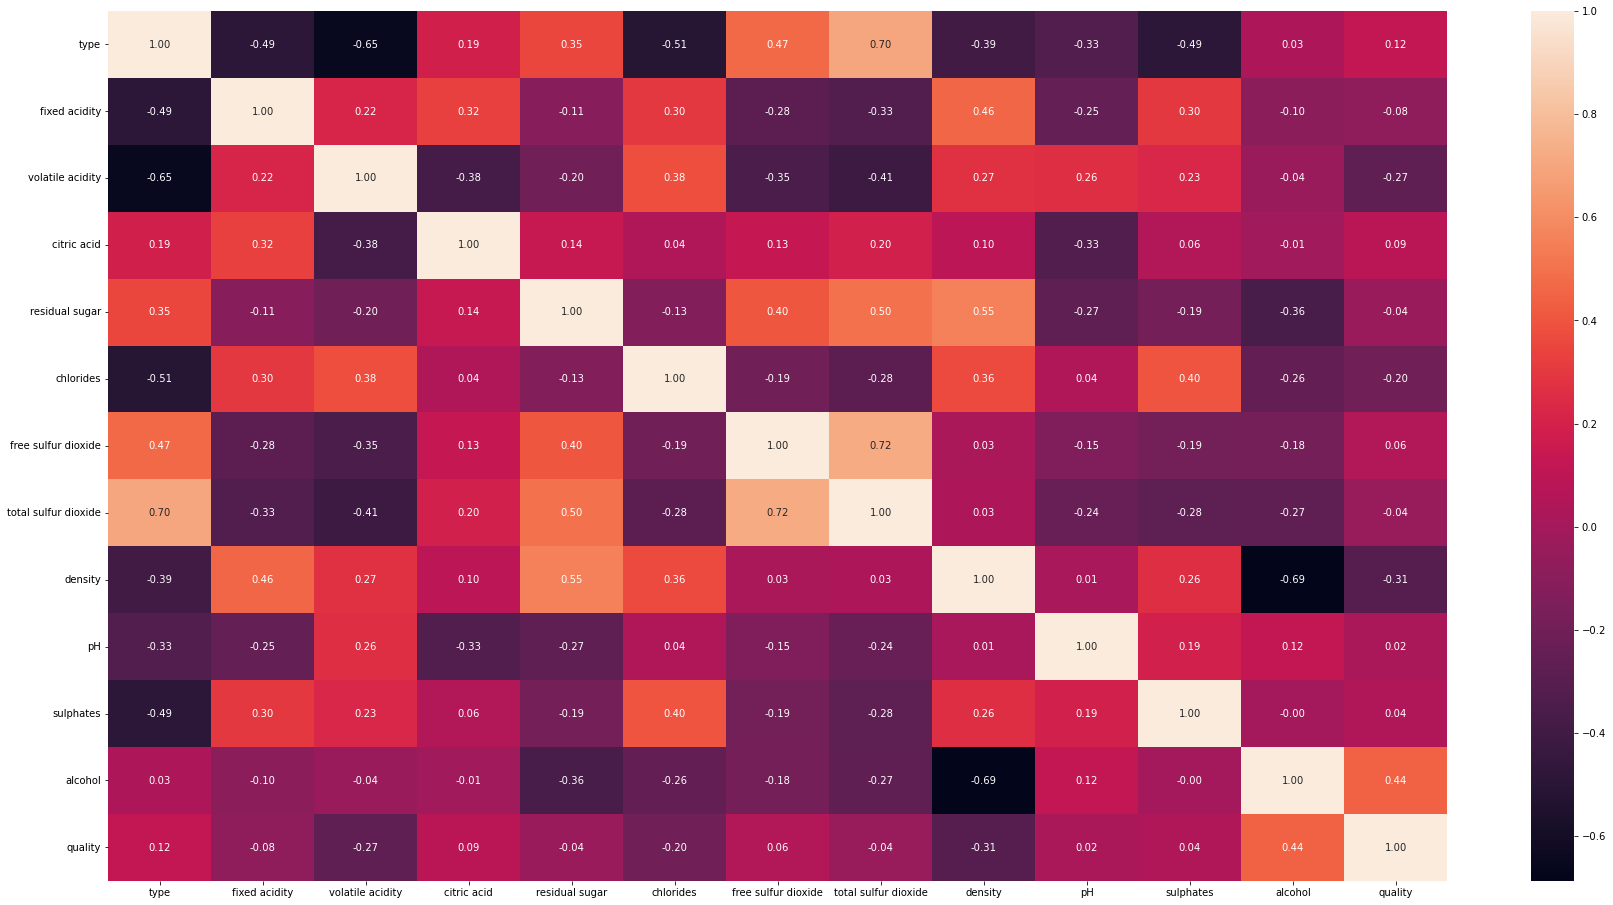

In [12]:
corr=data.corr()
plt.figure(figsize=(30,16))
sns.heatmap(corr,annot=True,fmt='.2f')

<Figure size 2160x1152 with 0 Axes>

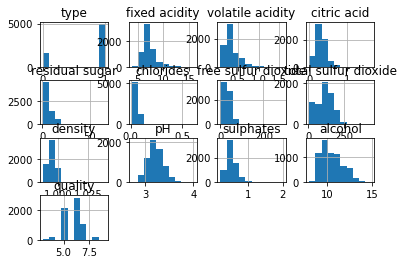

In [13]:
plt.figure(figsize=(30,16))
data.hist(bins=10);

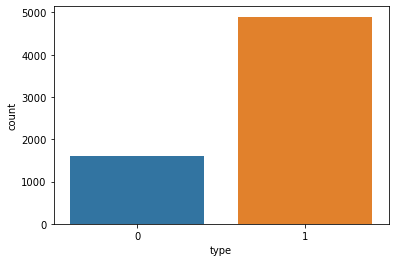

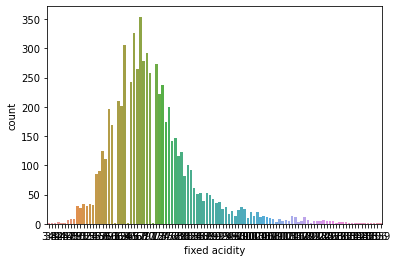

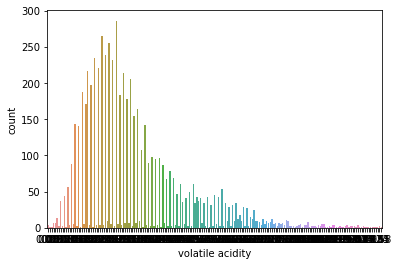

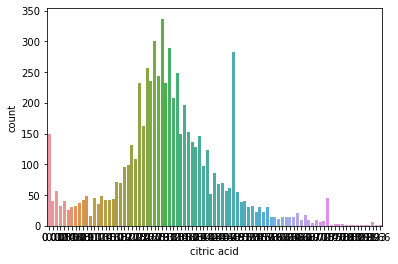

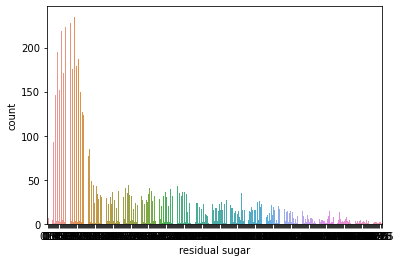

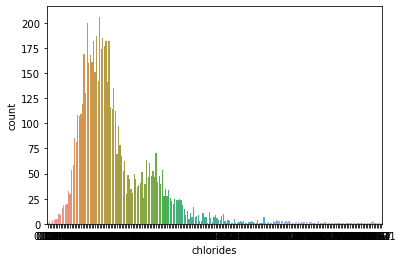

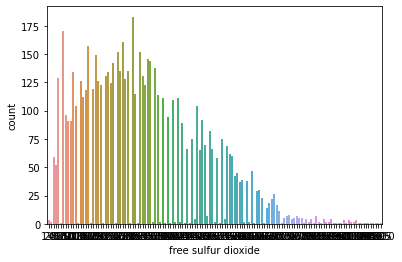

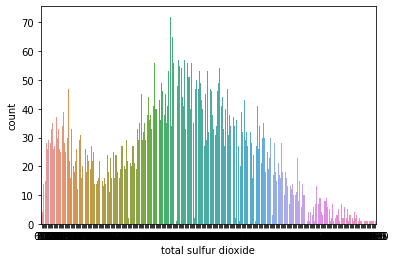

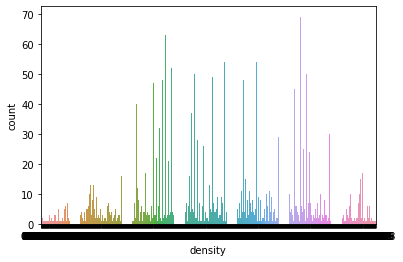

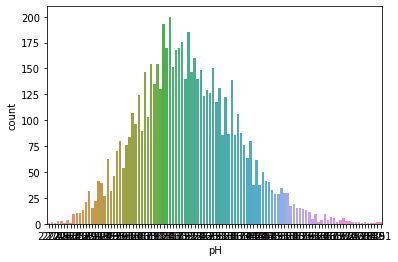

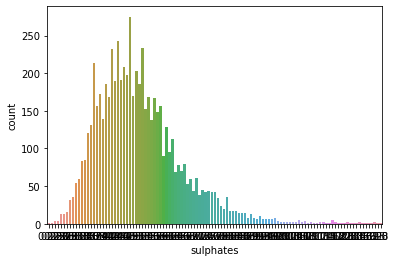

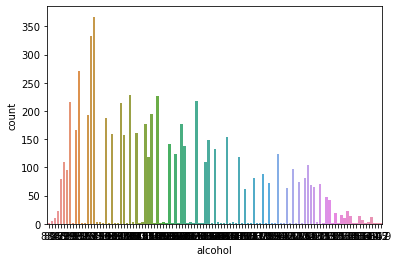

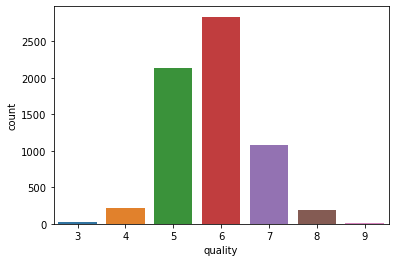

In [14]:
for column in data.columns:
    sns.countplot(data=data, x=column)
    plt.show()

## KNN Default

In [15]:
neighbors = [1, 3, 5, 7]
accuracies_default = {}
f1_scores_default = {}
precisions_default = {}
recalls_default = {}

for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy_default = accuracy_score(y_test, y_pred)
    f1_default = f1_score(y_pred, y_test, average='weighted')
    precision_default = precision_score(y_test, y_pred, average='weighted', zero_division = 1)
    recall_default = recall_score(y_test, y_pred, average='weighted')
    
    precisions_default[i] = precision_default
    recalls_default[i] = recall_default
    f1_scores_default[i] = f1_default
    accuracies_default[i] = accuracy_default
    
accuracies_default, f1_scores_default, precisions_default, recalls_default

({1: 0.6210256410256411,
  3: 0.5538461538461539,
  5: 0.5615384615384615,
  7: 0.5548717948717948},
 {1: 0.6244436741480085,
  3: 0.5584985526166586,
  5: 0.5735520240974091,
  7: 0.568559768543692},
 {1: 0.6151701268677953,
  3: 0.5478273872426711,
  5: 0.5545743943084404,
  7: 0.5477641475218736},
 {1: 0.6210256410256411,
  3: 0.5538461538461539,
  5: 0.5615384615384615,
  7: 0.5548717948717948})

## Random Forest Feature Importances

In [16]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

importances = rf.feature_importances_

feature_importances_rf = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
#feature_importances_rf = feature_importances_rf.sort_values('Importance', ascending=False)
feature_importances_rf_arr=np.array(feature_importances_rf['Importance'])

print(feature_importances_rf)

                 Feature  Importance
0                   type    0.004300
1          fixed acidity    0.075537
2       volatile acidity    0.098520
3            citric acid    0.078934
4         residual sugar    0.084064
5              chlorides    0.090220
6    free sulfur dioxide    0.085195
7   total sulfur dioxide    0.092809
8                density    0.101288
9                     pH    0.081714
10             sulphates    0.085307
11               alcohol    0.122111


## Random Forest Permutation Feature Importance

In [17]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

perm_importances = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

feature_importances_perm = pd.DataFrame({'Feature': X.columns,
                                    'Importance': perm_importances.importances_mean})

#feature_importances_perm = feature_importances_perm.sort_values('Importance', ascending=False)

feature_importances_perm_arr=np.array(feature_importances_perm['Importance'])

print(feature_importances_perm)

                 Feature  Importance
0                   type    0.002974
1          fixed acidity    0.005846
2       volatile acidity    0.087282
3            citric acid    0.016205
4         residual sugar    0.012410
5              chlorides    0.039282
6    free sulfur dioxide    0.027179
7   total sulfur dioxide    0.028564
8                density    0.033641
9                     pH    0.010154
10             sulphates    0.029897
11               alcohol    0.128154


## Correlation Feature Importance

In [18]:
corr_feat_imp=[0.12, 0.08, 0.27, 0.09, 0.04, 0.2, 0.06, 0.04, 0.31, 0.02, 0.04, 0.44]

corr_feat_imp=np.array(corr_feat_imp)

## Our Metric

In [19]:
@numba.njit(fastmath=True, parallel=True)
def euclidean_distance(point1, point2, feature_importances):
    squared_diff = (point1 - point2) ** 2
    weighted_squared_diff = squared_diff * feature_importances
    distance = np.sqrt(np.sum(weighted_squared_diff))
    return distance

def knn_predict(X_train, y_train, X_test, k, feature_importances):
    y_pred = []
    num_test_samples = len(X_test)
    num_train_samples = len(X_train)

    for i in range(num_test_samples):
        distances = []
        for j in range(num_train_samples):
            dist = euclidean_distance(X_test[i], X_train[j], feature_importances)
            distances.append((dist, y_train[j]))
        
        distances.sort(key=lambda x: x[0])  
        neighbors = distances[:k]  
        counts = {}  
        for neighbor in neighbors:
            label = neighbor[1]
            counts[label] = counts.get(label, 0) + 1
        
        predicted_label = max(counts, key=counts.get) 
        y_pred.append(predicted_label)
    
    return y_pred

In [20]:
X_train_ = X_train#[:100]
X_test_ = X_test#[:100]
y_train_ = y_train#[:100]
y_test_ = y_test#[:100]

In [21]:
# Random Forest Feature Importance

print("Random Forest Feature Importances")
print()

for i in neighbors:
    y_pred = knn_predict(X_train_, y_train_, X_test_, i, feature_importances_rf_arr)
    acc_rf = accuracy_score(y_pred, y_test_)
    f1_rf = f1_score(y_pred, y_test_, average='weighted')
    pre_rf = precision_score(y_test, y_pred, average='weighted', zero_division = 1)
    recall_rf = recall_score(y_test, y_pred, average='weighted')
    
    
    contribution_acc = (acc_rf - accuracies_default[i]) / acc_rf
    contribution_acc = "{:.3f}".format(contribution_acc)
    
    contribution_f1 = (f1_rf - f1_scores_default[i]) / f1_rf
    contribution_f1 = "{:.3f}".format(contribution_f1)
    
    print(f"Neighbors =",{i})
    print("Accuracy with RF Feature Importances:", acc_rf)
    print("F1 Score with RF Feature Importances:", f1_rf)
    print("F1 Score with RF Feature Importances:", pre_rf) 
    print("F1 Score with RF Feature Importances:", recall_rf) 
    
    print("Accuracy of KNN Default:", accuracies_default[i])
    print("F1 Score of KNN Default:", f1_scores_default[i])
    
    print()
    print("Accuracy Contribution of Our Metric: %", contribution_acc)
    print("F1 Score Contribution of Our Metric: %", contribution_f1)
    print()

Random Forest Feature Importances

Neighbors = {1}
Accuracy with RF Feature Importances: 0.62
F1 Score with RF Feature Importances: 0.6229300889151377
F1 Score with RF Feature Importances: 0.6148756822273248
F1 Score with RF Feature Importances: 0.62
Accuracy of KNN Default: 0.6210256410256411
F1 Score of KNN Default: 0.6244436741480085

Accuracy Contribution of Our Metric: % -0.002
F1 Score Contribution of Our Metric: % -0.002

Neighbors = {3}
Accuracy with RF Feature Importances: 0.5779487179487179
F1 Score with RF Feature Importances: 0.583279119738061
F1 Score with RF Feature Importances: 0.5710754921653926
F1 Score with RF Feature Importances: 0.5779487179487179
Accuracy of KNN Default: 0.5538461538461539
F1 Score of KNN Default: 0.5584985526166586

Accuracy Contribution of Our Metric: % 0.042
F1 Score Contribution of Our Metric: % 0.042

Neighbors = {5}
Accuracy with RF Feature Importances: 0.5692307692307692
F1 Score with RF Feature Importances: 0.5776491332046888
F1 Score with 

In [22]:
# Random Forest Permutation Feature Importance

print("RF Permutation Feature Importances")
print()

for i in neighbors:
    y_pred = knn_predict(X_train_, y_train_, X_test_, i, feature_importances_perm_arr)
    acc_perm = accuracy_score(y_pred, y_test)
    f1_perm = f1_score(y_pred, y_test_, average='weighted')
    pre_perm = precision_score(y_test, y_pred, average='weighted', zero_division = 1)
    recall_perm = recall_score(y_test, y_pred, average='weighted')

    print(f"Neighbors =",{i})
    print("Accuracy with RF Permutation Feature Importances", acc_perm)
    print("F1 Score with RF Permutation Feature Importances:", f1_perm)
    print("F1 Score with RF Permutation Feature Importances:", pre_perm)
    print("F1 Score with RF Permutation Feature Importances:", recall_perm)
    print("Accuracy of KNN Default", accuracies_default[i])
    print("F1 Score of KNN Default:", f1_scores_default[i])
    print()

RF Permutation Feature Importances

Neighbors = {1}
Accuracy with RF Permutation Feature Importances 0.6082051282051282
F1 Score with RF Permutation Feature Importances: 0.6104056361951177
F1 Score with RF Permutation Feature Importances: 0.6050003096884784
F1 Score with RF Permutation Feature Importances: 0.6082051282051282
Accuracy of KNN Default 0.6210256410256411
F1 Score of KNN Default: 0.6244436741480085

Neighbors = {3}
Accuracy with RF Permutation Feature Importances 0.5707692307692308
F1 Score with RF Permutation Feature Importances: 0.5766870744623981
F1 Score with RF Permutation Feature Importances: 0.5630889701783203
F1 Score with RF Permutation Feature Importances: 0.5707692307692308
Accuracy of KNN Default 0.5538461538461539
F1 Score of KNN Default: 0.5584985526166586

Neighbors = {5}
Accuracy with RF Permutation Feature Importances 0.5507692307692308
F1 Score with RF Permutation Feature Importances: 0.5605995106221688
F1 Score with RF Permutation Feature Importances: 0.5

In [ ]:
# Correlation Feature Importance

print("Correlation Feature Importances")

for i in neighbors:
    y_pred = knn_predict(X_train_, y_train_, X_test_, i, corr_feat_imp)
    acc_corr = accuracy_score(y_pred, y_test_)
    f1_corr = f1_score(y_pred, y_test_, average='weighted')
    pre_corr = precision_score(y_test, y_pred, average='weighted', zero_division = 1)
    recall_corr = recall_score(y_test, y_pred, average='weighted')


    print(f"Neighbors =",{i})
    print("Accuracy with Correlation Feature Importances", acc_corr)
    print("F1 Score with Correlation Feature Importances:", f1_corr)
    print("F1 Score with Correlation Feature Importances:", pre_corr)
    print("F1 Score with Correlation Feature Importances:", recall_corr)
    print("Accuracy of KNN Default", accuracies_default[i])
    print("F1 Score of KNN Default:", f1_scores_default[i])
    print()

Correlation Feature Importances
